In [28]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from pathlib import Path
import torch
import os
from denoising_diffusion_pytorch import Unet1D, GaussianDiffusion1D, Trainer1D, Dataset1D

In [3]:
proj_dir = Path("..") / "Data/r77-mini-data-fortnight"
print(proj_dir.joinpath("input"))

data_dir = proj_dir
input_dir = data_dir.joinpath("input")
fixed_input_dir = input_dir.joinpath("fixed")
temporal_input_dir = input_dir.joinpath("temporal")
target_dir = data_dir.joinpath("target")
fixed_target_dir = target_dir.joinpath("fixed")
temporal_target_dir = target_dir.joinpath("temporal")

../Data/r77-mini-data-fortnight/input


In [4]:
files = list(temporal_target_dir.iterdir())

index_dir = Path("..")/"Index"
files_index = list(index_dir.iterdir())
indices = np.load(files_index[0]).squeeze()

In [5]:
tt_all = np.stack([
    np.transpose(np.load(files[indices[i]]).squeeze(), (0, 2, 3, 1))[:,:,:,:64].reshape(-1, 3, 64)
    for i in range(360)
])

data = tt_all.reshape(-1,3,64)
data.shape

(5184000, 3, 64)

In [6]:
num_steps = {
    1000: 'Samples_0',
    10000: 'Samples_1',
    100000: 'Samples_2'
}

j = 100000


sample_dir = Path(num_steps[j])
files_sample = list(sample_dir.iterdir())

sample = np.load(files_sample[0]).squeeze()
sample.shape

(10000, 3, 64)

In [12]:
sample0_dir = Path('Samples_0')
files_sample0 = list(sample0_dir.iterdir())

sample0 = np.load(files_sample0[0]).squeeze()
sample0.shape

(10000, 3, 64)

In [14]:
random_indices = np.random.choice(data.shape[0], 100, replace=False)
trainingdata = data[random_indices]

random_indices = np.random.choice(sample.shape[0], 100, replace=False)
samples = sample[random_indices]

random_indices = np.random.choice(sample0.shape[0], 100, replace=False)
samples0 = sample0[random_indices]

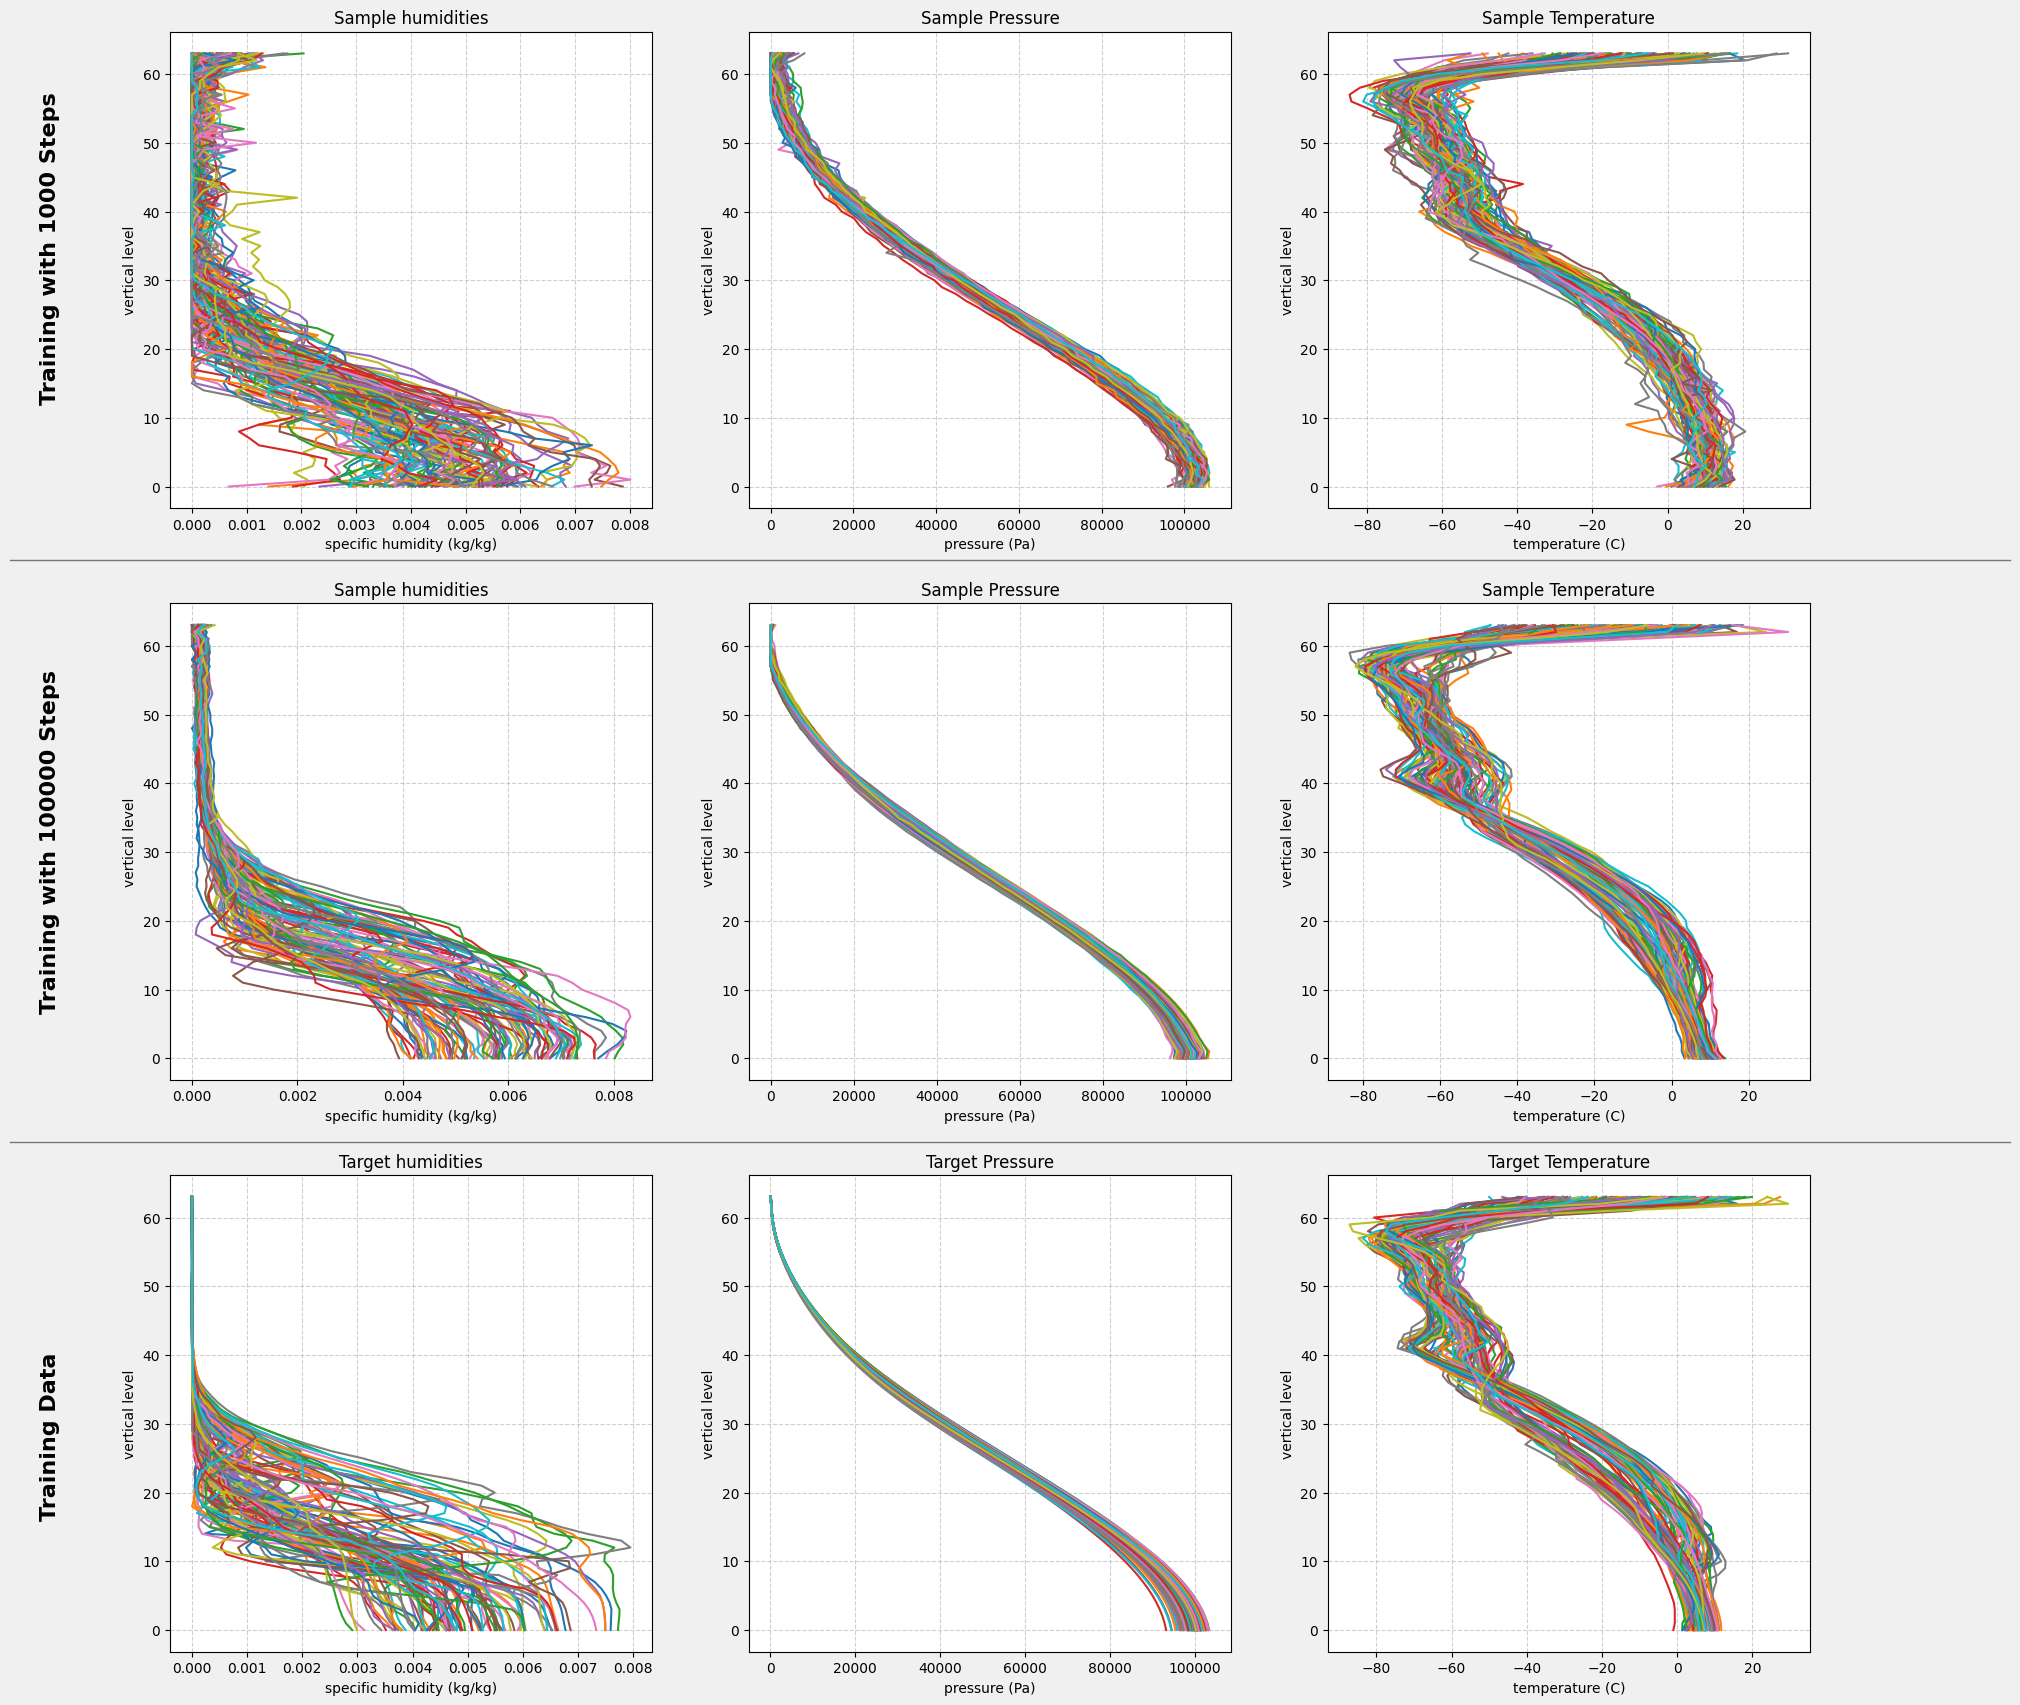

In [61]:
fig, axs = plt.subplots(3, 3, figsize=(20, 18))

fig.patch.set_facecolor('#f0f0f0')

#Sample humidities plot
sample_humidity = samples0[:, 0, :] * 0.025
for i in range(100):
    axs[0,0].plot(sample_humidity[i], np.arange(64))
axs[0,0].set_xlabel("specific humidity (kg/kg)")
axs[0,0].set_ylabel("vertical level")
axs[0,0].set_title("Sample humidities")
axs[0,0].grid(True, linestyle='--', alpha=0.6)

#Sample humidities plot
sample_humidity = samples[:, 0, :] * 0.025
for i in range(100):
    axs[1,0].plot(sample_humidity[i], np.arange(64))
axs[1,0].set_xlabel("specific humidity (kg/kg)")
axs[1,0].set_ylabel("vertical level")
axs[1,0].set_title("Sample humidities")
axs[1,0].grid(True, linestyle='--', alpha=0.6)


# Target humidities plot
target_humidity = trainingdata[:, 0, :] * 0.025
for i in range(100):
    axs[2,0].plot(target_humidity[i], np.arange(64))
axs[2,0].set_xlabel("specific humidity (kg/kg)")
axs[2,0].set_ylabel("vertical level")
axs[2,0].set_title("Target humidities")
axs[2,0].grid(True, linestyle='--', alpha=0.6)

#Sample pressure plot
sample_pressure = samples0[:, 1, :] * 106000
for i in range(100):
    axs[0,1].plot(sample_pressure[i], np.arange(64))
axs[0,1].set_xlabel("pressure (Pa)")
axs[0,1].set_ylabel("vertical level")
axs[0,1].set_title("Sample Pressure")
axs[0,1].grid(True, linestyle='--', alpha=0.6)

#Sample pressure plot
sample_pressure = samples[:, 1, :] * 106000
for i in range(100):
    axs[1,1].plot(sample_pressure[i], np.arange(64))
axs[1,1].set_xlabel("pressure (Pa)")
axs[1,1].set_ylabel("vertical level")
axs[1,1].set_title("Sample Pressure")
axs[1,1].grid(True, linestyle='--', alpha=0.6)

# Target pressure plot
target_pressure = trainingdata[:, 1, :] * 106000
for i in range(100):
    axs[2,1].plot(target_pressure[i], np.arange(64))
axs[2,1].set_xlabel("pressure (Pa)")
axs[2,1].set_ylabel("vertical level")
axs[2,1].set_title("Target Pressure")
axs[2,1].grid(True, linestyle='--', alpha=0.6)

#Sample temperature plot
sample_temperature = samples0[:, 2, :]* 180 + 140 -273.15
for i in range(100):
    axs[0,2].plot(sample_temperature[i], np.arange(64))
axs[0,2].set_xlabel("temperature (\u00B0C)")
axs[0,2].set_ylabel("vertical level")
axs[0,2].set_title("Sample Temperature")
axs[0,2].grid(True, linestyle='--', alpha=0.6)

#Sample temperature plot
sample_temperature = samples[:, 2, :]* 180 + 140 -273.15
for i in range(100):
    axs[1,2].plot(sample_temperature[i], np.arange(64))
axs[1,2].set_xlabel("temperature (\u00B0C)")
axs[1,2].set_ylabel("vertical level")
axs[1,2].set_title("Sample Temperature")
axs[1,2].grid(True, linestyle='--', alpha=0.6)

# Target pressure plot
target_temperature = trainingdata[:, 2, :]* 180 + 140 -273.15
for i in range(100):
    axs[2,2].plot(target_temperature[i], np.arange(64))
axs[2,2].set_xlabel("temperature (\u00B0C)")
axs[2,2].set_ylabel("vertical level")
axs[2,2].set_title("Target Temperature")
axs[2,2].grid(True, linestyle='--', alpha=0.6)

# Add titles on the left-hand side, rotated
fig.text(0.02, 0.83, 'Training with 1000 Steps', va='center', ha='center', fontsize=16, fontweight='bold', rotation='vertical')
fig.text(0.02, 0.50, 'Training with 100000 Steps', va='center', ha='center', fontsize=16, fontweight='bold', rotation='vertical')
fig.text(0.02, 0.17, 'Training Data', va='center', ha='center', fontsize=16, fontweight='bold', rotation='vertical')


fig.add_artist(plt.Line2D([0, 1], [1 - 1/3 -0.01, 1 - 1/3 -0.01], color='black', lw=1,alpha = 0.5))
fig.add_artist(plt.Line2D([0, 1], [1 - 2/3, 1 - 2/3], color='black', lw=1,alpha = 0.5))

# Adjust layout to ensure everything fits nicely
plt.subplots_adjust(left=0.08, hspace=0.2, top=0.95, bottom=0.05)

plt.show()

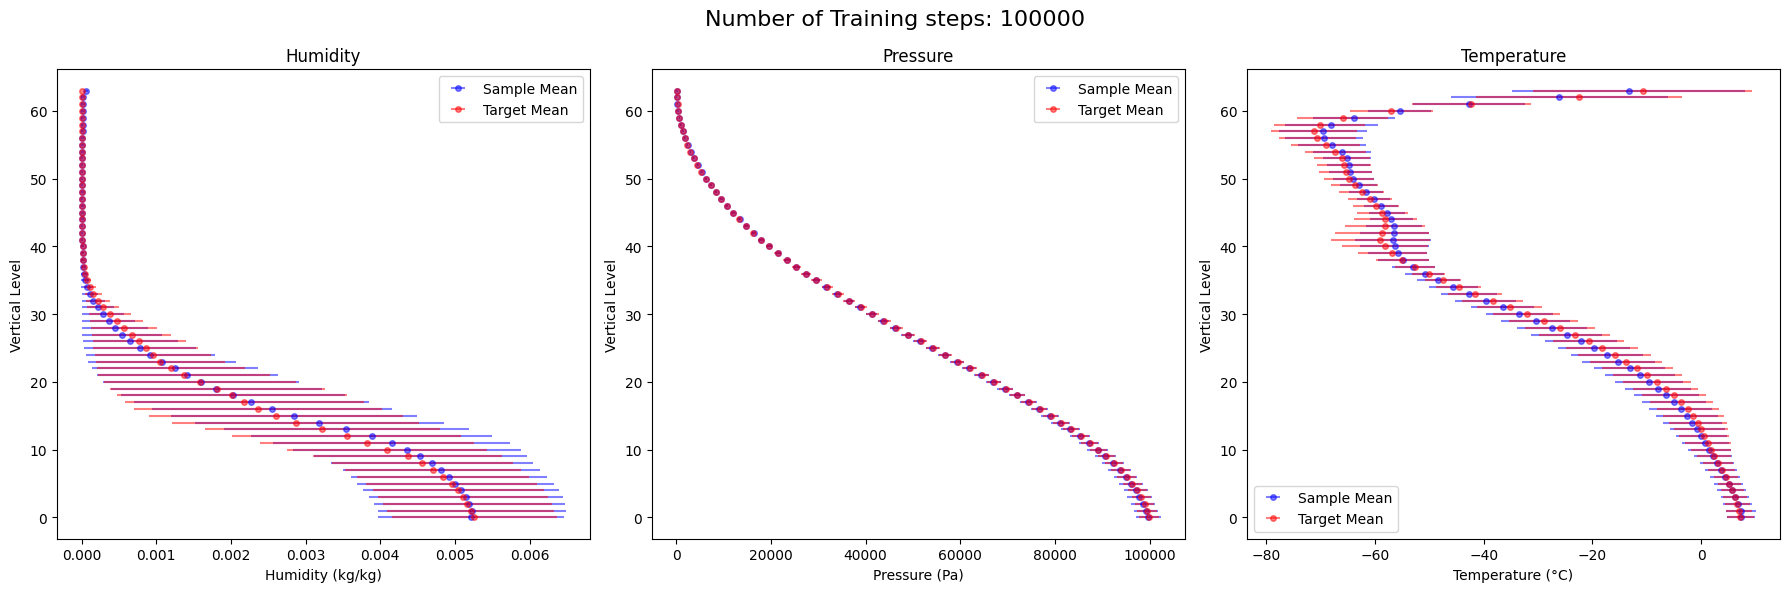

In [17]:
#humid
target_mean_1h = np.mean(target_humidity, axis= 0)
sample_mean_1h = np.mean(sample_humidity, axis=0)
target_variance_1h= np.var(target_humidity, axis= 0)
sample_variance_1h = np.var(sample_humidity, axis=0)

#press
target_mean_1p = np.mean(target_pressure, axis= 0)
sample_mean_1p = np.mean(sample_pressure, axis=0)
target_variance_1p= np.var(target_pressure, axis= 0)
sample_variance_1p = np.var(sample_pressure, axis=0)

#temp
target_mean_1t = np.mean(target_temperature, axis= 0)
sample_mean_1t = np.mean(sample_temperature, axis=0)
target_variance_1t= np.var(target_temperature, axis= 0)
sample_variance_1t = np.var(sample_temperature, axis=0)



fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].errorbar(sample_mean_1h, np.arange(64), xerr=np.sqrt(sample_variance_1h), fmt='o', label='Sample Mean', markersize=4, color='blue', ecolor='blue', alpha=0.5)
axs[0].errorbar(target_mean_1h, np.arange(64), xerr=np.sqrt(target_variance_1h), fmt='o', label='Target Mean', markersize=4, color='red', ecolor='red', alpha=0.5)
axs[0].set_title('Humidity')
axs[0].set_xlabel('Humidity (kg/kg)')
axs[0].set_ylabel('Vertical Level')
axs[0].legend()

axs[1].errorbar(sample_mean_1p, np.arange(64), xerr=np.sqrt(sample_variance_1p), fmt='o', label='Sample Mean', markersize=4, color='blue', ecolor='blue', alpha=0.5)
axs[1].errorbar(target_mean_1p, np.arange(64), xerr=np.sqrt(target_variance_1p), fmt='o', label='Target Mean', markersize=4, color='red', ecolor='red', alpha=0.5)
axs[1].set_title('Pressure')
axs[1].set_xlabel('Pressure (Pa)')
axs[1].set_ylabel('Vertical Level')
axs[1].legend()


axs[2].errorbar(sample_mean_1t, np.arange(64), xerr=np.sqrt(sample_variance_1t), fmt='o', label='Sample Mean', markersize=4, color='blue', ecolor='blue', alpha=0.5)
axs[2].errorbar(target_mean_1t, np.arange(64), xerr=np.sqrt(target_variance_1t), fmt='o', label='Target Mean', markersize=4, color='red', ecolor='red', alpha=0.5)
axs[2].set_title('Temperature')
axs[2].set_xlabel('Temperature (\u00B0C)')
axs[2].set_ylabel('Vertical Level')
axs[2].legend()

fig.suptitle(f'Number of Training steps: {j}', fontsize = 16)
plt.tight_layout()


plt.show()


